In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sciStat
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import time


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst

LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker       = xt.Tracker(line=line[_beam])
        twiss[_beam]  = tracker.twiss().to_pandas(index="name")
        survey[_beam] = tracker.survey().to_pandas(index="name")
    elif _beam == 'b4':
        _tracker      = xt.Tracker(line=line[_beam])
        twiss['b2']   = _tracker.twiss().reverse().to_pandas(index="name")
        survey['b2']  = _tracker.survey().reverse().to_pandas(index="name")


# Filtering twiss
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================

# Clearing xsuite ouput
clear_output(wait=False)


B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)

---
# Test 1D
---

In [21]:

dx_vec = np.linspace(1,20,100)

# Parameters

_ax = [1e-6,1,6]
_ay = [1e-6,6,1]
_fw = 3
_dy = 0

sig_s_x,sig_s_y = 200e-6 , 1.2*200e-6
sig_w_x,sig_w_y = 250e-6 , 250e-6
_r     = sig_s_y/sig_s_x
_A_w_s = sig_w_x/sig_s_y
_B_w_s = sig_w_y/sig_s_x



# FOR LR
LR_results_x = []
LR_results_y = []
LR_results_t = []
IP  = IP1
_bb = IP.lr.loc['bb_lr.l1b1_01']   
for _dx in dx_vec:
    


    s_time = time.time()
    _DQx,_DQy = dtune.DQx_DQy(  fw     = _fw,
                                ax     = _ax,
                                ay     = _ay,
                                r      = _r,
                                dx_sig = _dx,
                                dy_sig = _dy,
                                A_w_s  = _A_w_s,
                                B_w_s  = _B_w_s,
                                xi     = IP.b2.xi)
    e_time = time.time()
    LR_results_x.append(_DQx)
    LR_results_y.append(_DQy)
    LR_results_t.append(e_time-s_time)


# FOR OCt
Oc_results_x = []
Oc_results_y = []
Oc_results_t = []

for _dx in dx_vec:
    
    k1 = IP.b2.strong_knl(_dx*sig_s_x,_dy*sig_s_y)[0][1]
    k3 = IP.b2.strong_knl(_dx*sig_s_x,_dy*sig_s_y)[0][3]

    betx  =  sig_w_x**2 / IP.b1.emittx  #IP.b2.xi*4*np.pi*IP.b2.gamma_r/IP.b2.Nb/cst.r_p
    bety  =  sig_w_y**2 / IP.b1.emitty

    s_time = time.time()
    _DQx,_DQy = dtune.BBLR_octupole(  Jx   = np.array(_ax)**2*IP.b2.emittx/2,
                                      Jy   = np.array(_ay)**2*IP.b2.emittx/2,
                                      betx = betx,
                                      bety = bety,
                                      k1   = k1,
                                      k3   = k3)
    e_time = time.time()
    Oc_results_x.append(_DQx)
    Oc_results_y.append(_DQy)
    Oc_results_t.append(e_time-s_time)




/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.exp(-u1-u2)/2/np.pi*integrate.quad(lambda phi:
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:46: RuntimeWarning: overflow encountered in exp
  return np.cos(n*phi) * np.exp( u1*np.cos(phi) + u2*np.cos(2*phi))
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should

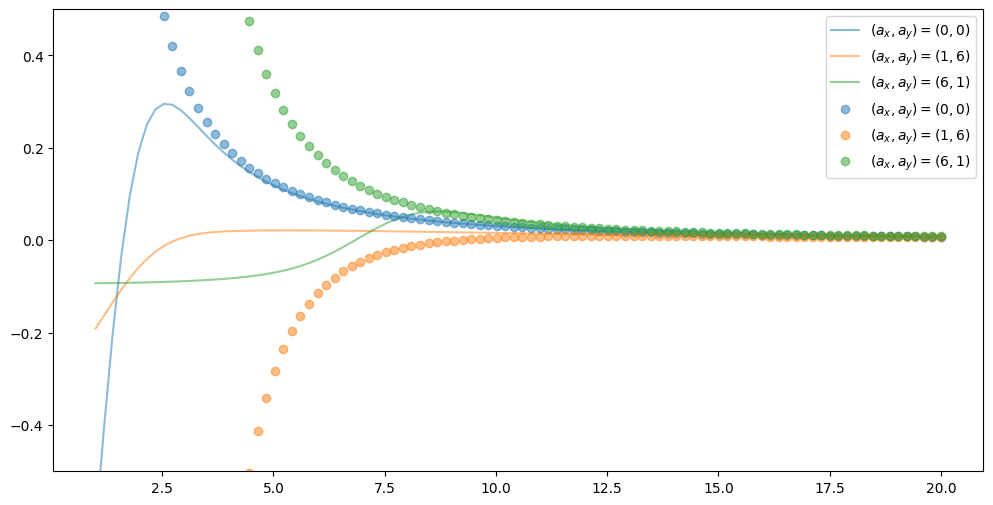

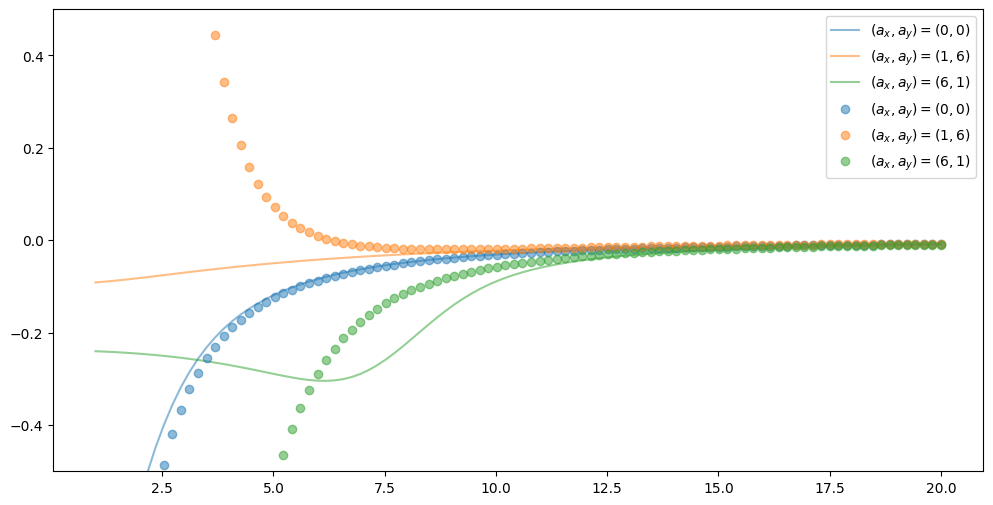

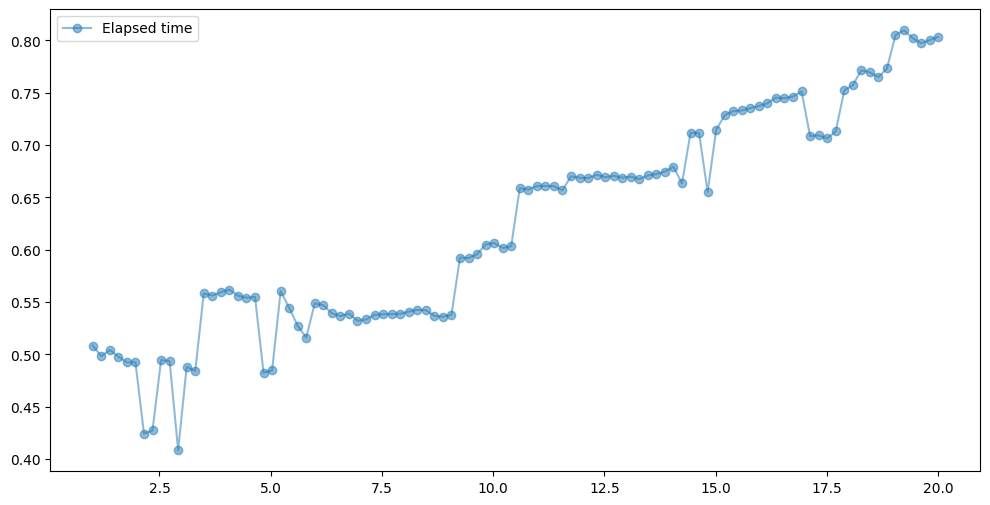

In [20]:
plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_x,Oc_results_x],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.5,0.5])
plt.legend()

plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_y,Oc_results_y],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.5,0.5])
plt.legend()


plt.figure(figsize=(12,6))
plt.plot(dx_vec,np.array(LR_results_t),'-o',color='C0',alpha=0.5,label=r'Elapsed time')
plt.legend()

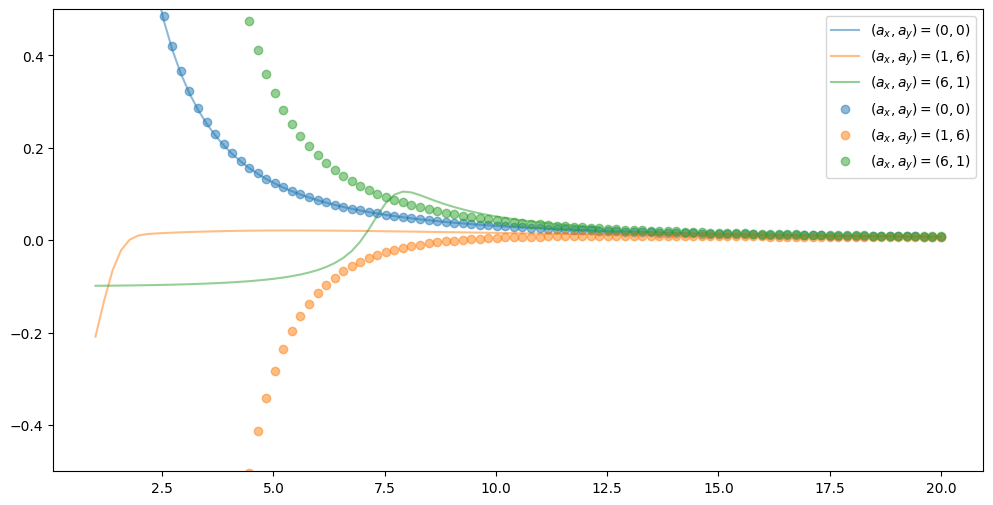

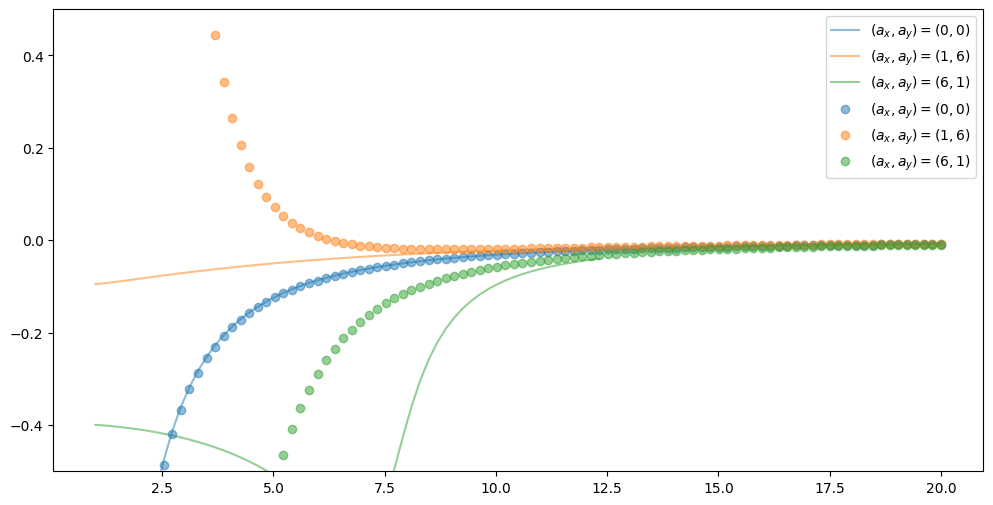

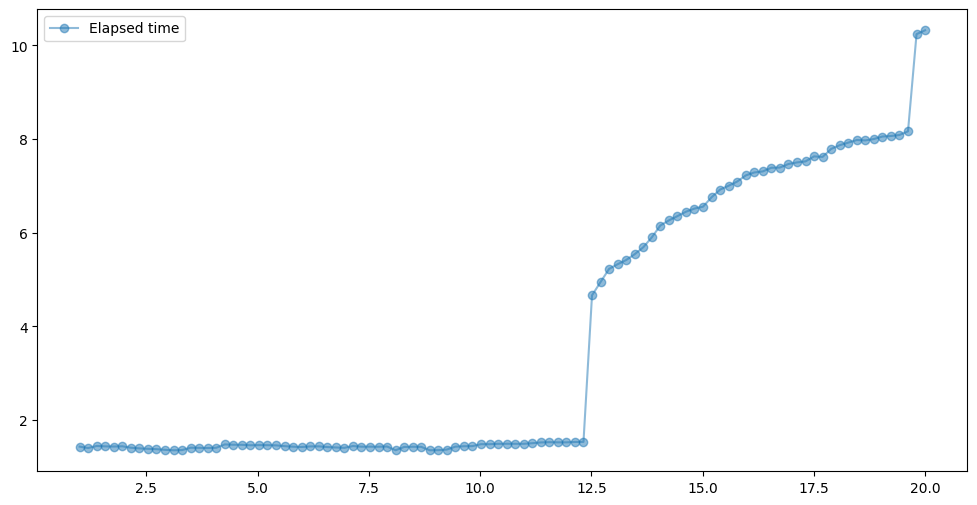

In [22]:
plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_x,Oc_results_x],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.5,0.5])
plt.legend()

plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_y,Oc_results_y],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.5,0.5])
plt.legend()


plt.figure(figsize=(12,6))
plt.plot(dx_vec,np.array(LR_results_t),'-o',color='C0',alpha=0.5,label=r'Elapsed time')
plt.legend()

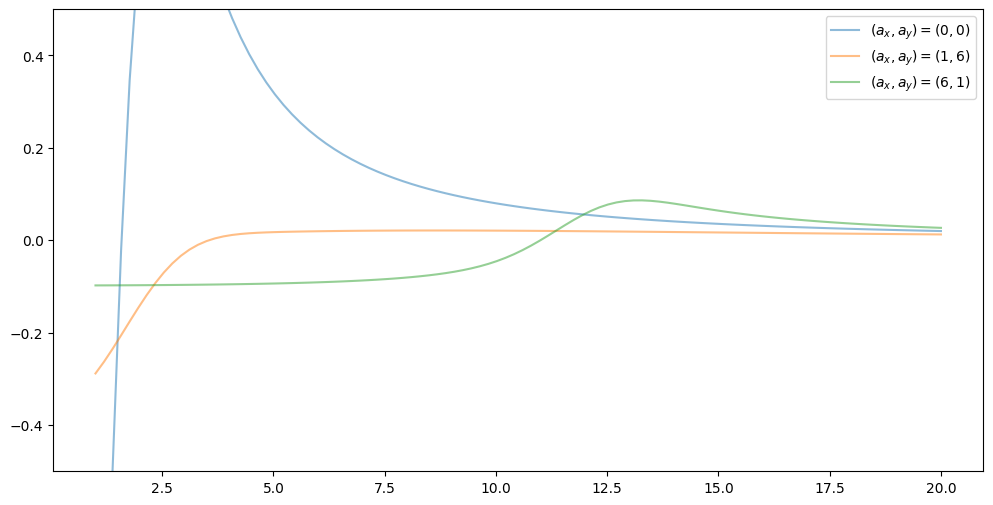

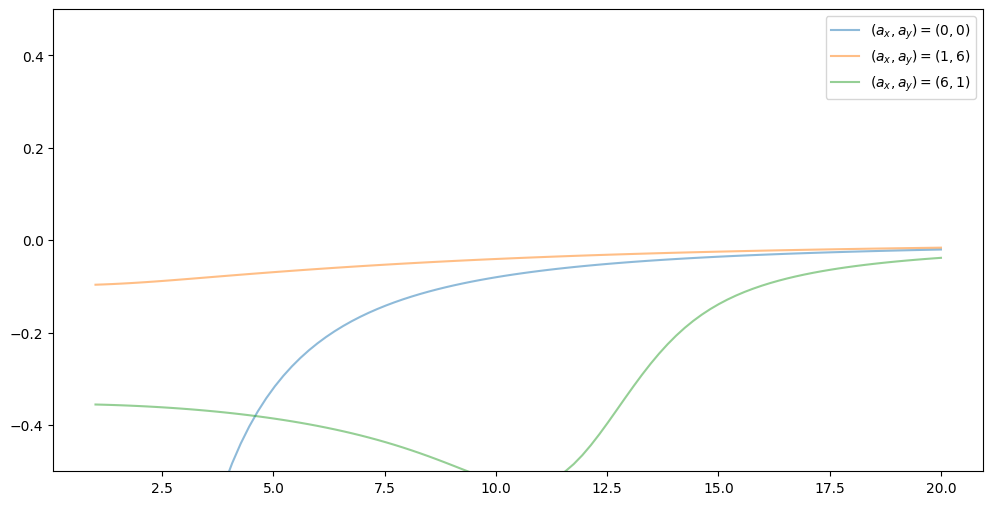

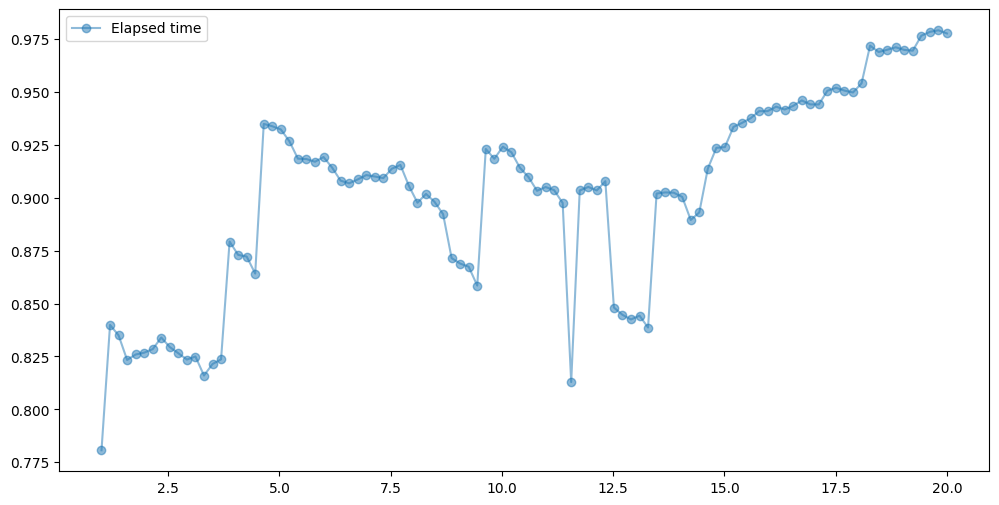

In [67]:

dx_vec = np.linspace(1,20,100)

# Parameters

_ax = [1e-6,1,6]
_ay = [1e-6,6,1]
_fw = 1
_dy = 0

sig_s_x,sig_s_y = 100e-6 , 100e-6
sig_w_x,sig_w_y = 200e-6 , 200e-6
_r     = sig_s_y/sig_s_x
_A_w_s = sig_w_x/sig_s_y
_B_w_s = sig_w_y/sig_s_x



# FOR LR
LR_results_x = []
LR_results_y = []
LR_results_t = []
IP  = IP1
_bb = IP.lr.loc['bb_lr.l1b1_01']   
for _dx in dx_vec:
    


    s_time = time.time()
    _DQx,_DQy = dtune.DQx_DQy(  fw     = _fw,
                                ax     = _ax,
                                ay     = _ay,
                                r      = _r,
                                dx_sig = _dx,
                                dy_sig = _dy,
                                A_w_s  = _A_w_s,
                                B_w_s  = _B_w_s,
                                xi     = IP.b2.xi)
    e_time = time.time()
    LR_results_x.append(_DQx)
    LR_results_y.append(_DQy)
    LR_results_t.append(e_time-s_time)


# FOR OCt
Oc_results_x = []
Oc_results_y = []
Oc_results_t = []

for _dx in dx_vec:
    
    k1 = IP.b2.strong_knl(_dx*sig_s_x,_dy*sig_s_y)[0][1]
    k3 = IP.b2.strong_knl(_dx*sig_s_x,_dy*sig_s_y)[0][3]

    betx  =  sig_w_x**2 / IP.b1.emittx  #IP.b2.xi*4*np.pi*IP.b2.gamma_r/IP.b2.Nb/cst.r_p
    bety  =  sig_w_y**2 / IP.b1.emitty

    s_time = time.time()
    _DQx,_DQy = dtune.BBLR_octupole(  Jx   = np.array(_ax)**2*IP.b2.emittx/2,
                                      Jy   = np.array(_ay)**2*IP.b2.emittx/2,
                                      betx = betx,
                                      bety = bety,
                                      k1   = k1,
                                      k3   = k3)
    e_time = time.time()
    Oc_results_x.append(_DQx)
    Oc_results_y.append(_DQy)
    Oc_results_t.append(e_time-s_time)


plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_x],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.5,0.5])
plt.legend()

plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_y],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.5,0.5])
plt.legend()


plt.figure(figsize=(12,6))
plt.plot(dx_vec,np.array(LR_results_t),'-o',color='C0',alpha=0.5,label=r'Elapsed time')
plt.legend()

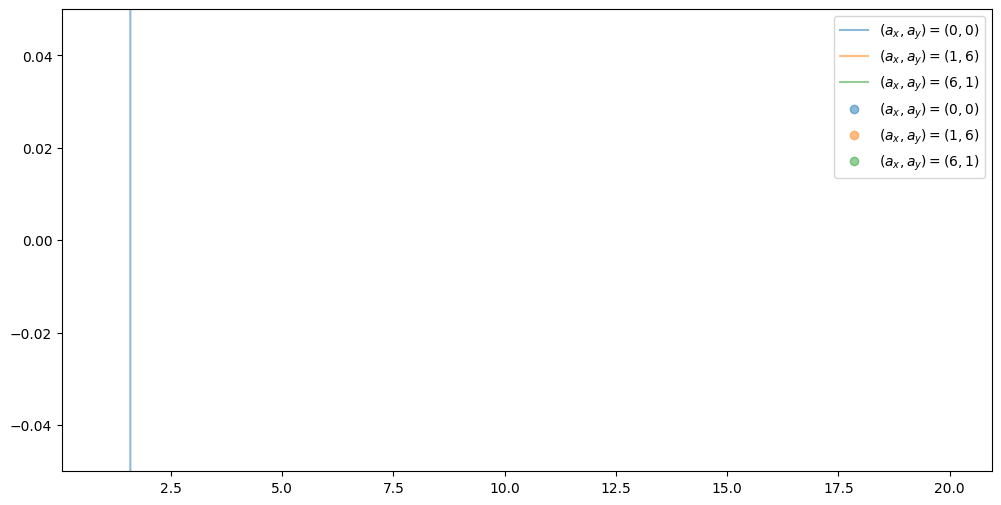

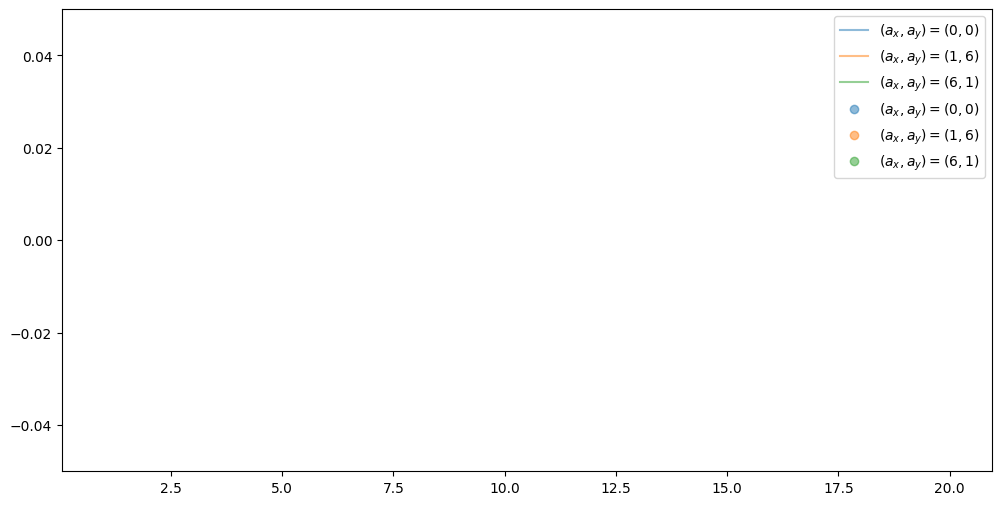

In [66]:
plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_x,Oc_results_x],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.05,0.05])
plt.legend()

plt.figure(figsize=(12,6))
for results,ls in zip([LR_results_y,Oc_results_y],['-','o']):
    plt.plot(dx_vec,np.array(results)[:,0]/IP.b2.xi,ls,color='C0',alpha=0.5,label=r'$(a_x,a_y) = (0,0)$')
    plt.plot(dx_vec,np.array(results)[:,1]/IP.b2.xi,ls,color='C1',alpha=0.5,label=r'$(a_x,a_y) = (1,6)$')
    plt.plot(dx_vec,np.array(results)[:,2]/IP.b2.xi,ls,color='C2',alpha=0.5,label=r'$(a_x,a_y) = (6,1)$')
plt.ylim([-0.05,0.05])
plt.legend()

/tmp/ipykernel_198160/1551332557.py:40: RuntimeWarning: invalid value encountered in double_scalars
  term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])


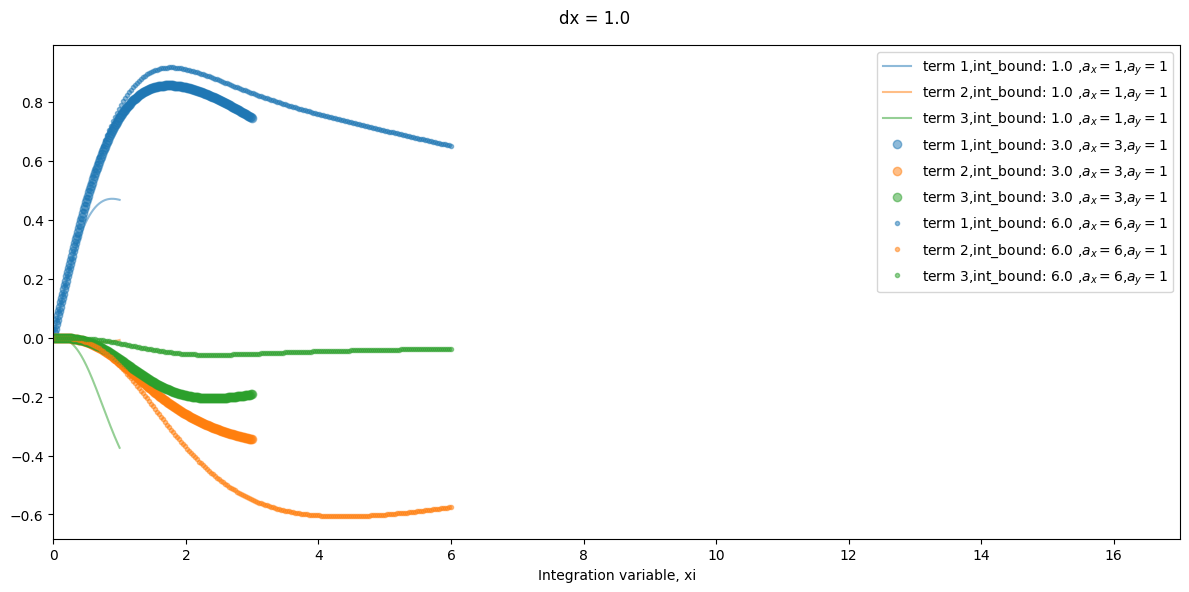

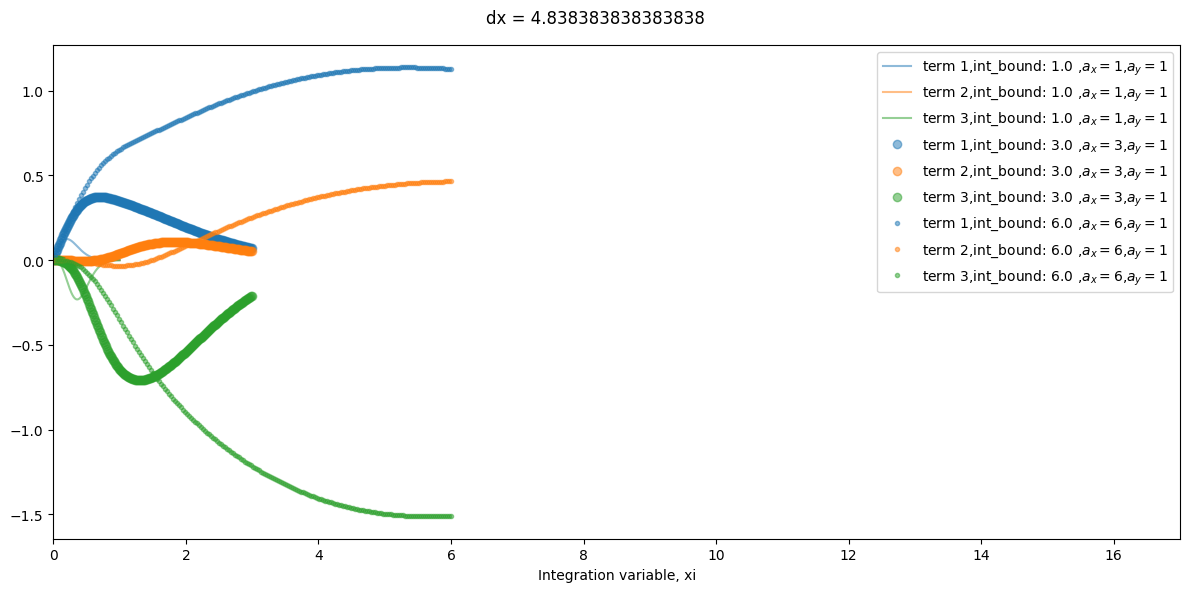

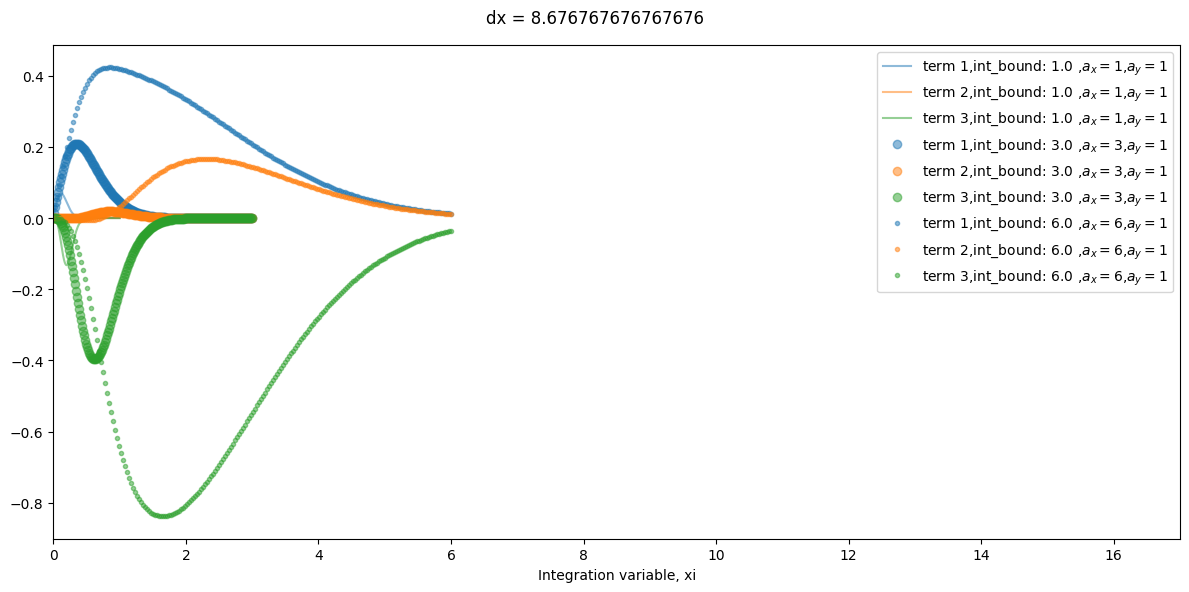

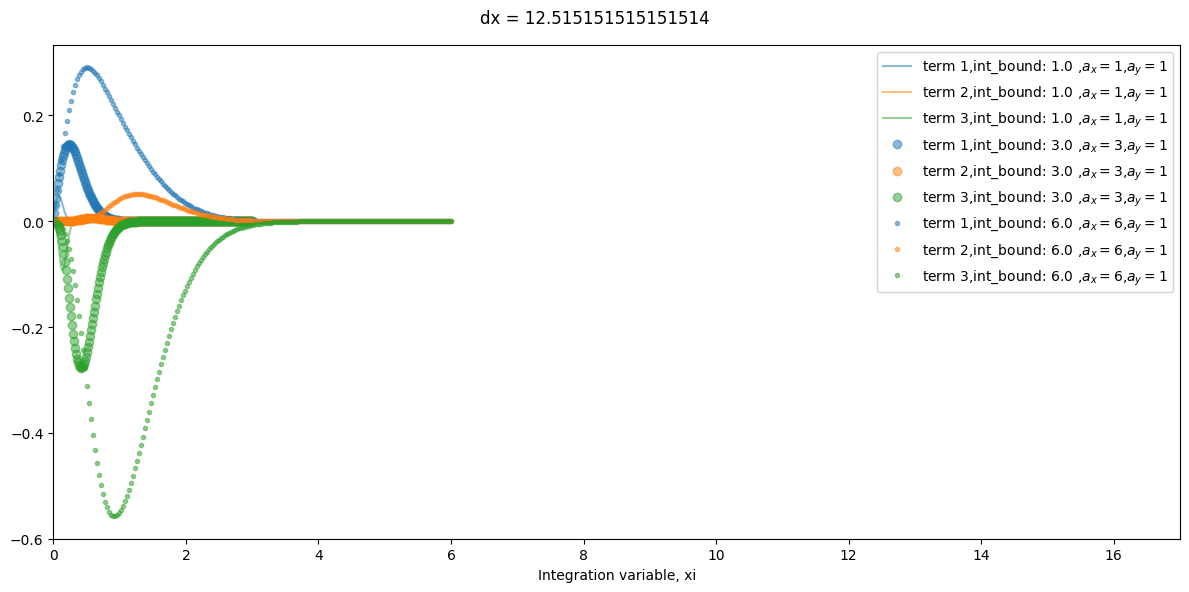

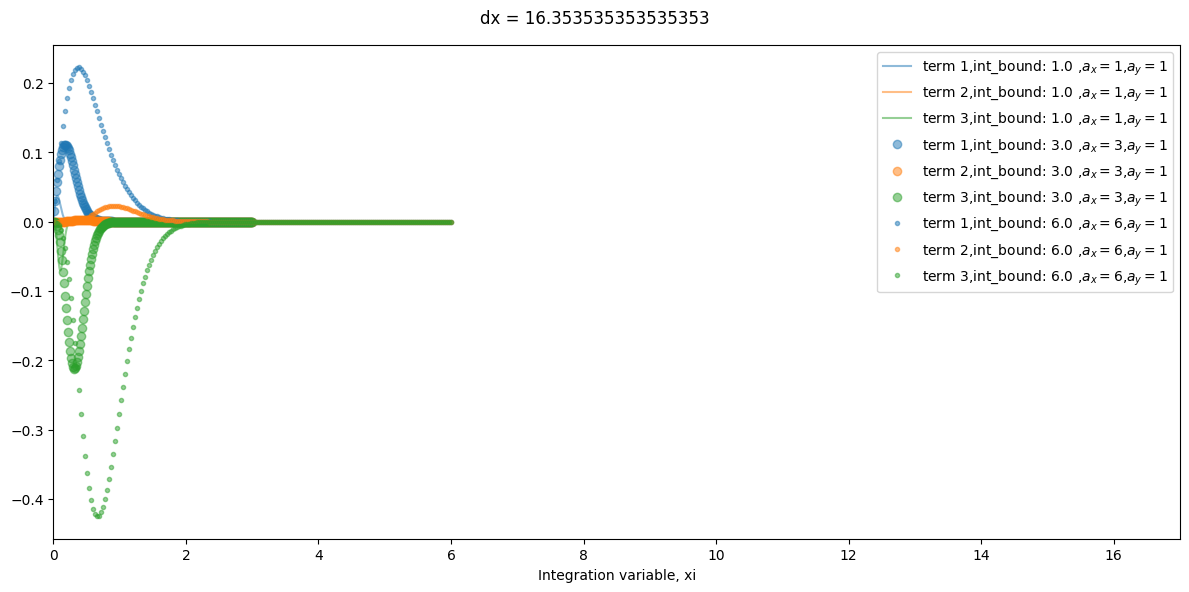

In [57]:



dx_vec = np.linspace(1,20,100)
ax = [1,3,6]
ay = [1,1,1]

_fw = 1
_dy = 0

sig_s_x,sig_s_y = 200e-6 , 200e-6
sig_w_x,sig_w_y = 200e-6 , 200e-6
_r     = sig_s_y/sig_s_x
_A_w_s = sig_w_x/sig_s_y
_B_w_s = sig_w_y/sig_s_x



# FOR LR

for _dx in dx_vec[::20]:

    plt.figure(figsize=(12,6))
    plt.suptitle(f'dx = {_dx}')
    for _ax,_ay,ls in zip(ax,ay,['-','o','.','x','p','s']):

        phi = np.linspace(0,_r*_ax*_fw,200)


        psix = _dx/_ax/_r
        psiy = _ay/_ax/_r
        psiz = _dy/_ax

        axb = phi
        ayb = phi*psiy
        dxb = phi*psix
        dyb = phi*psiz


        # Maybe phi*term?
        term1 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,0) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term2 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,2)  ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])

        plt.plot(phi,phi*term1,ls,color='C0',alpha=0.5,label=rf'term 1,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
        plt.plot(phi,phi*term2,ls,color='C1',alpha=0.5,label=rf'term 2,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
        plt.plot(phi,phi*term3,ls,color='C2',alpha=0.5,label=rf'term 3,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
    plt.legend()
    plt.xlabel('Integration variable, xi')
    plt.xlim([0,17])
    plt.tight_layout()


/tmp/ipykernel_198160/1551332557.py:40: RuntimeWarning: invalid value encountered in double_scalars
  term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])


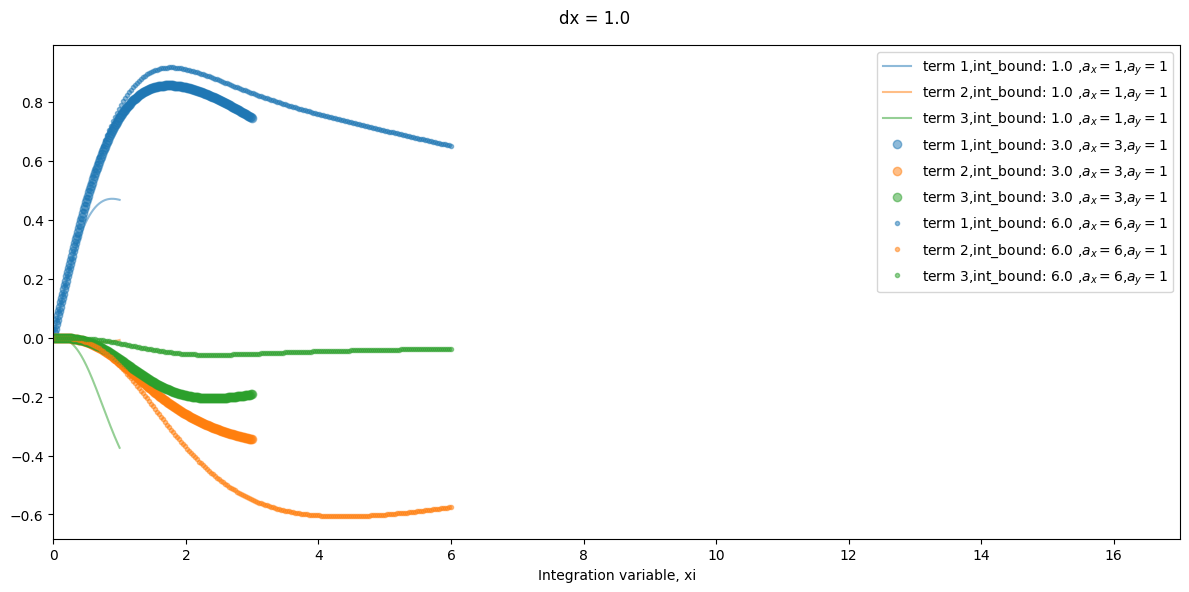

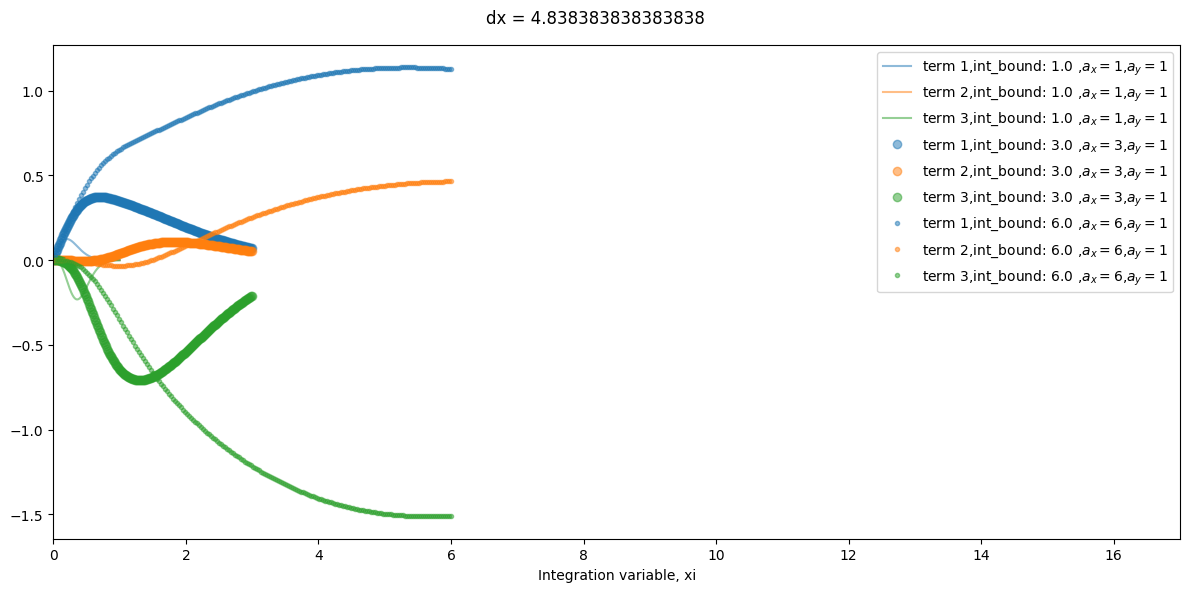

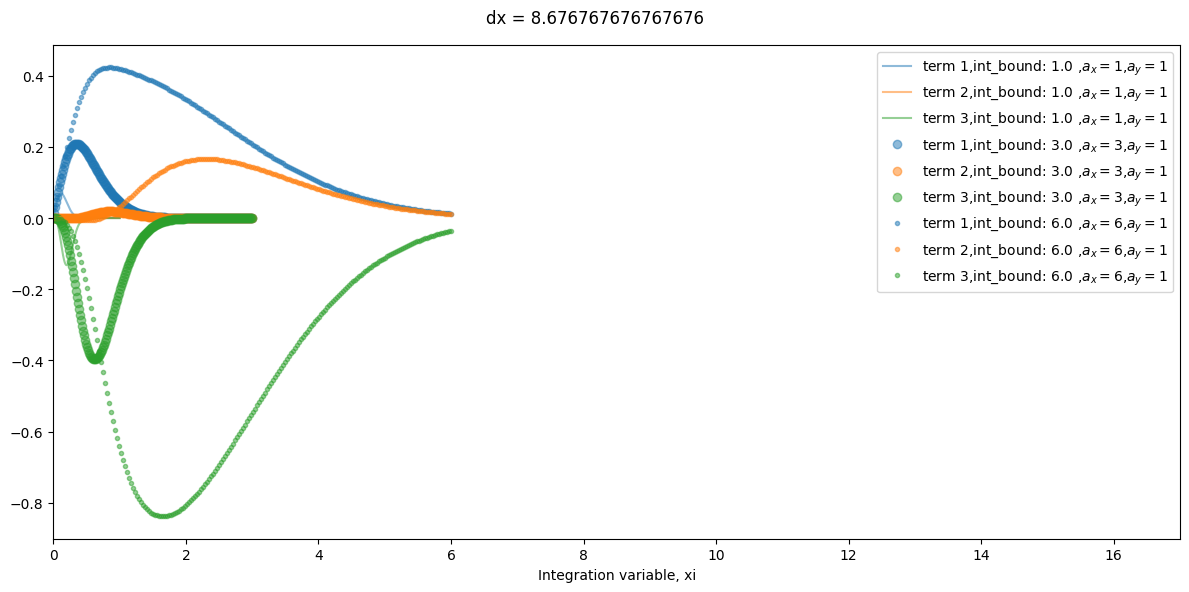

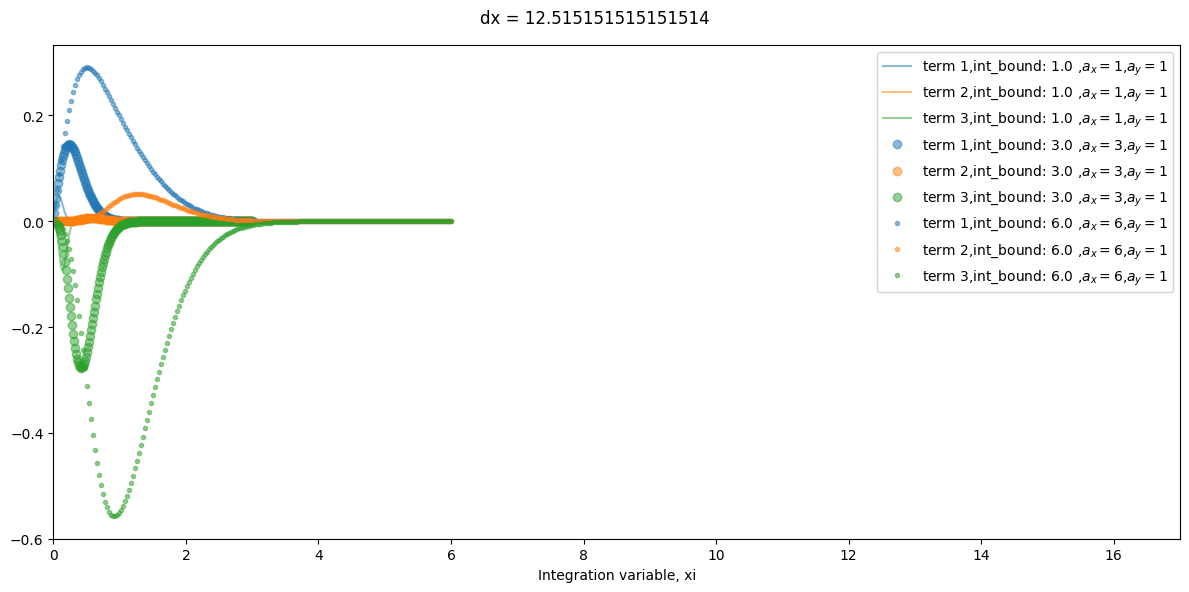

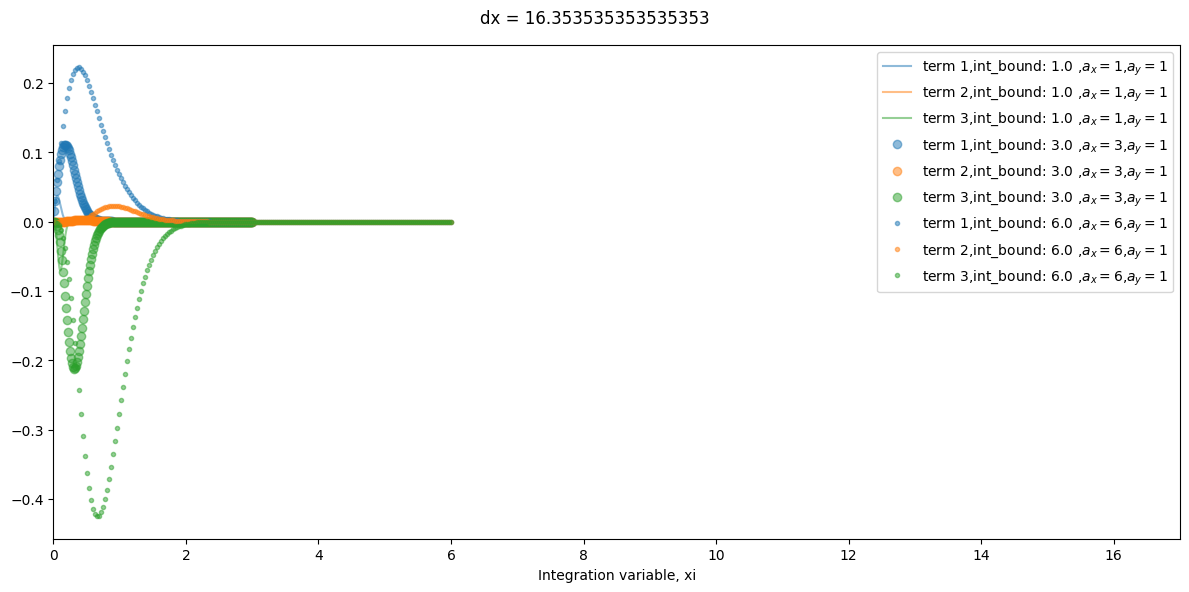

In [50]:



dx_vec = np.linspace(1,20,100)
ax = [1,3,6]
ay = [1,1,1]

_fw = 1
_dy = 0

sig_s_x,sig_s_y = 200e-6 , 200e-6
sig_w_x,sig_w_y = 200e-6 , 200e-6
_r     = sig_s_y/sig_s_x
_A_w_s = sig_w_x/sig_s_y
_B_w_s = sig_w_y/sig_s_x



# FOR LR

for _dx in dx_vec[::20]:

    plt.figure(figsize=(12,6))
    plt.suptitle(f'dx = {_dx}')
    for _ax,_ay,ls in zip(ax,ay,['-','o','.','x','p','s']):

        phi = np.linspace(0,_r*_ax*_fw,200)


        psix = _dx/_ax/_r
        psiy = _ay/_ax/_r
        psiz = _dy/_ax

        axb = phi
        ayb = phi*psiy
        dxb = phi*psix
        dyb = phi*psiz


        # Maybe phi*term?
        term1 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,0) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term2 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,2)  ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])

        plt.plot(phi,phi*term1,ls,color='C0',alpha=0.5,label=rf'term 1,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
        plt.plot(phi,phi*term2,ls,color='C1',alpha=0.5,label=rf'term 2,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
        plt.plot(phi,phi*term3,ls,color='C2',alpha=0.5,label=rf'term 3,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
    plt.legend()
    plt.xlabel('Integration variable, xi')
    plt.xlim([0,17])
    plt.tight_layout()


/tmp/ipykernel_198160/2999921589.py:44: RuntimeWarning: invalid value encountered in double_scalars
  term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])


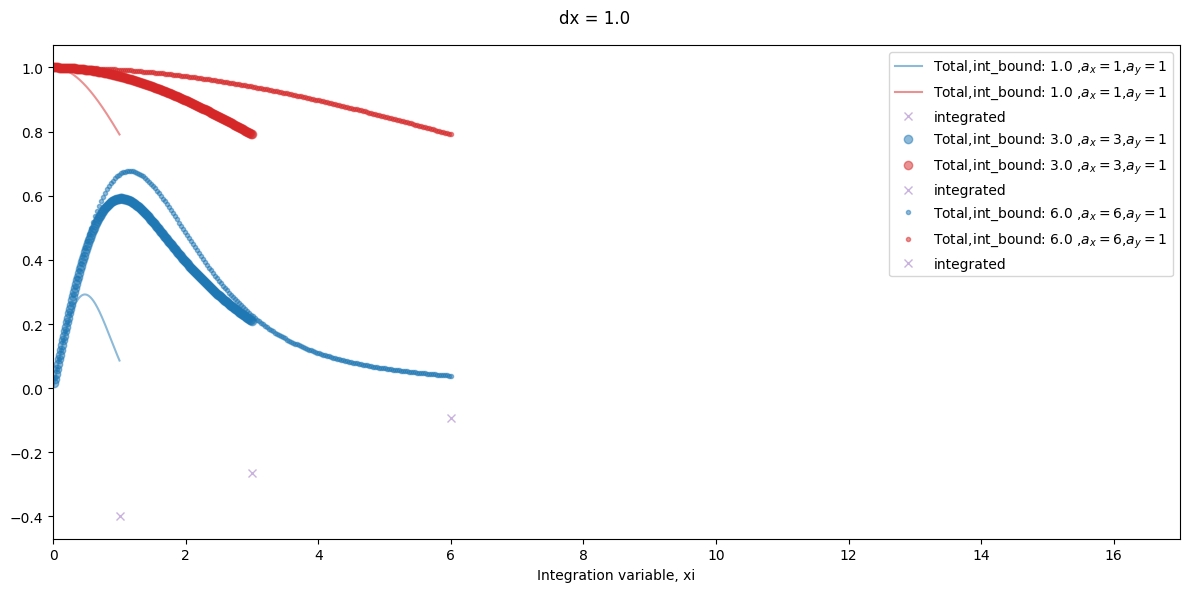

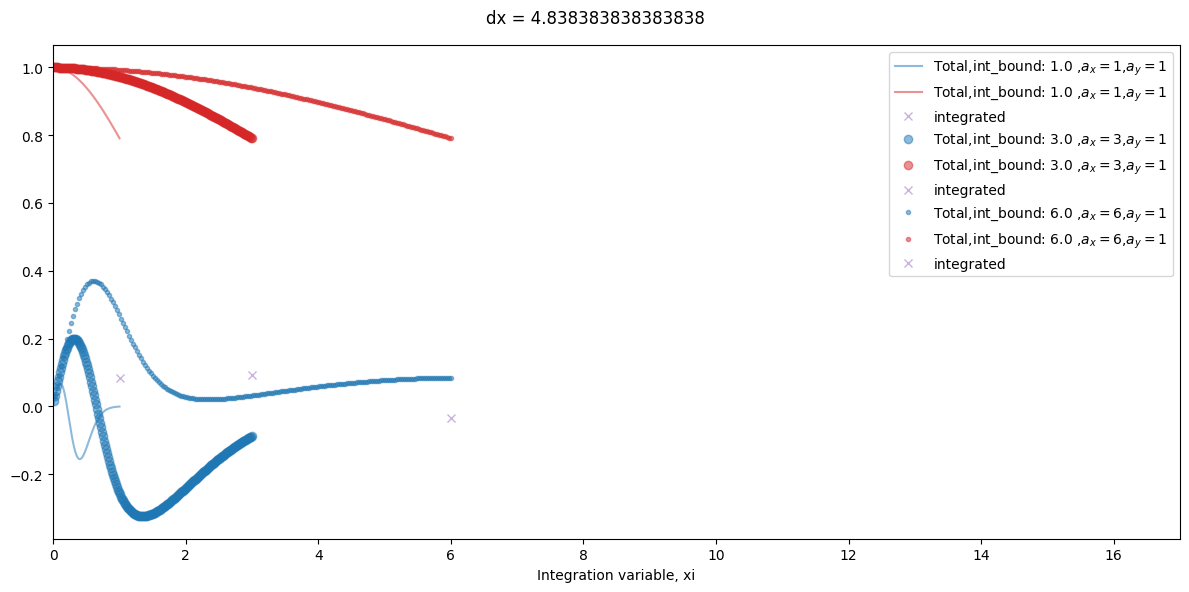

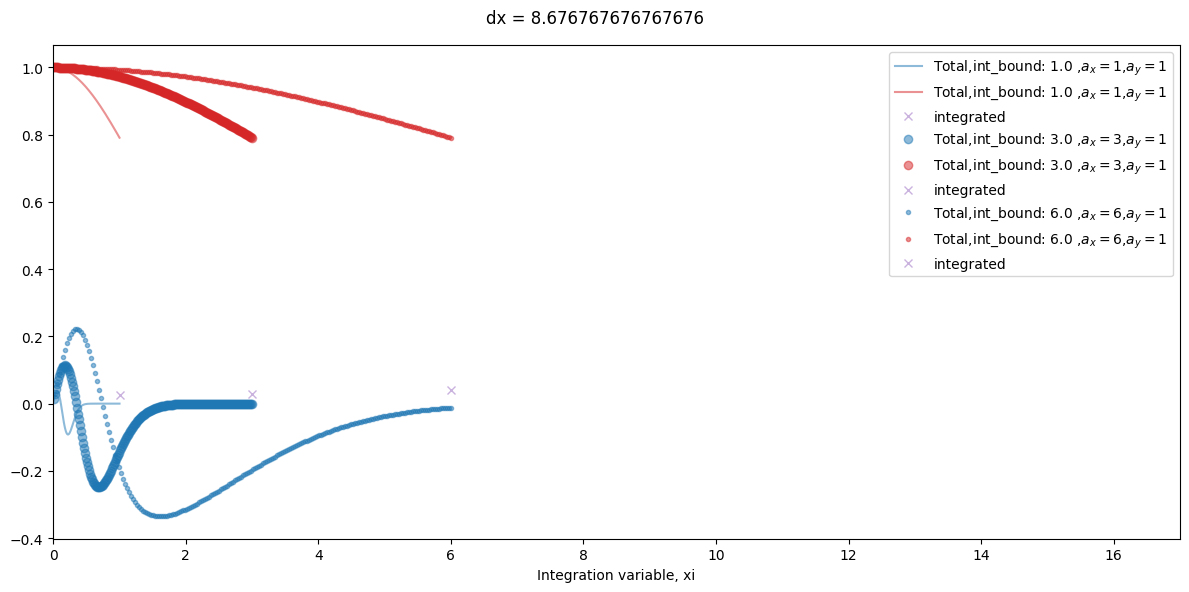

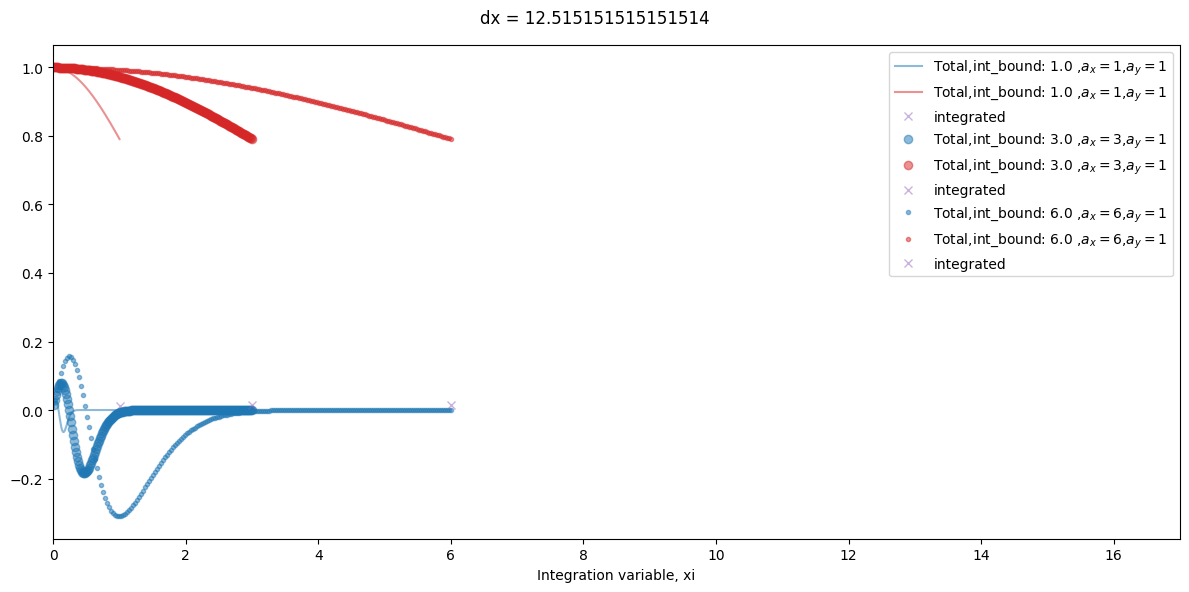

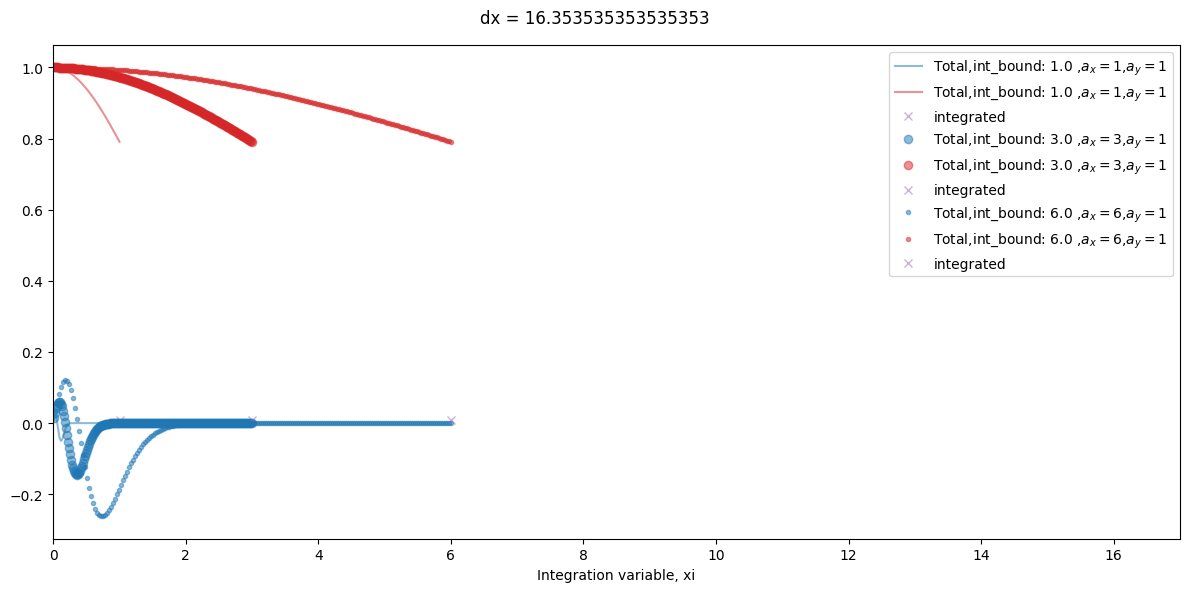

In [56]:
import scipy.integrate as integrate


dx_vec = np.linspace(1,20,100)
ax = [1,3,6]
ay = [1,1,1]

_fw = 1
_dy = 0

sig_s_x,sig_s_y = 200e-6 , 200e-6
sig_w_x,sig_w_y = 200e-6 , 200e-6
_r     = sig_s_y/sig_s_x
_A_w_s = sig_w_x/sig_s_y
_B_w_s = sig_w_y/sig_s_x



# FOR LR

for _dx in dx_vec[::20]:

    plt.figure(figsize=(12,6))
    plt.suptitle(f'dx = {_dx}')
    for _ax,_ay,ls in zip(ax,ay,['-','o','.','x','p','s']):

        phi = np.linspace(0,_r*_ax*_fw,200)


        psix = _dx/_ax/_r
        psiy = _ay/_ax/_r
        psiz = _dy/_ax

        axb = phi
        ayb = phi*psiy
        dxb = phi*psix
        dyb = phi*psiz


        # Maybe phi*term?
        prefactor = np.array([dtune.Qmz(_ayb,_dyb,0) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term1 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,0) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term2 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,2)  ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])

        _i   = 0
        _f   = _r*_ax
        integral = (-2/_ax**2) * integrate.quad(lambda phi:
                                        phi*dtune.TSX_kern(   axb = phi,
                                                                    ayb = phi*psiy,
                                                                    dxb = phi*psix,
                                                                    dyb = phi*psiz),_i,_f)[0]

        plt.plot(phi,phi*(term1+term2+term3),ls,color='C0',alpha=0.5,label=rf'Total,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
        plt.plot(phi,prefactor,ls,color='C3',alpha=0.5,label=rf'Total,int_bound: {_r*_ax*_fw} ,$a_x = {_ax}$,$a_y = 1$')
        plt.plot(_ax,integral,'x',color='C4',alpha=0.5,label=rf'integrated')
       
       
    plt.legend()
    plt.xlabel('Integration variable, xi')
    plt.xlim([0,17])
    plt.tight_layout()


/tmp/ipykernel_198160/3658531179.py:40: RuntimeWarning: invalid value encountered in double_scalars
  term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(-u1-u2)/2/np.pi*integrate.quad(lambda phi:
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:62: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-t/2*(azb-dzb)**2)*Bess2D(u1,u2,n)
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: RuntimeWarning: overflow encountered in exp
  return np.exp(-u1-u2)/2/np.pi*integrate.quad(lambda phi:


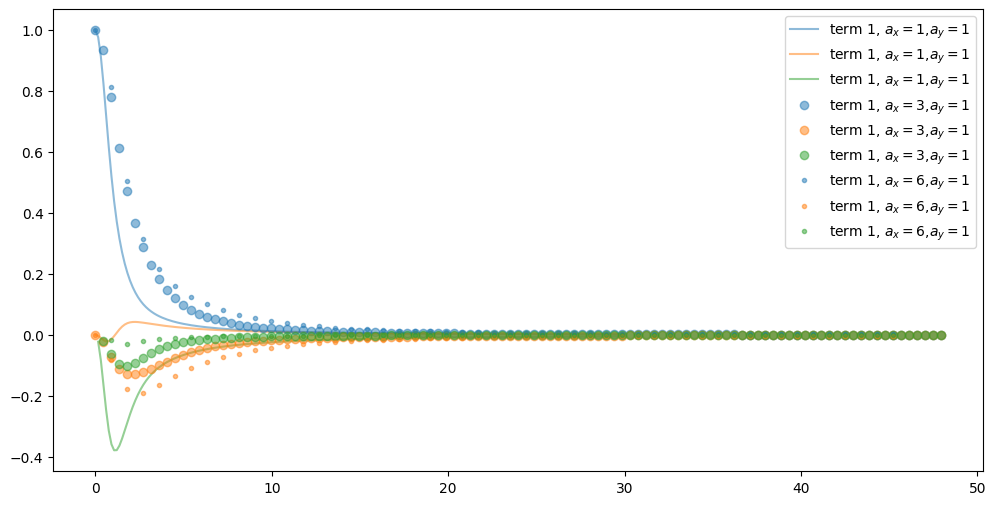

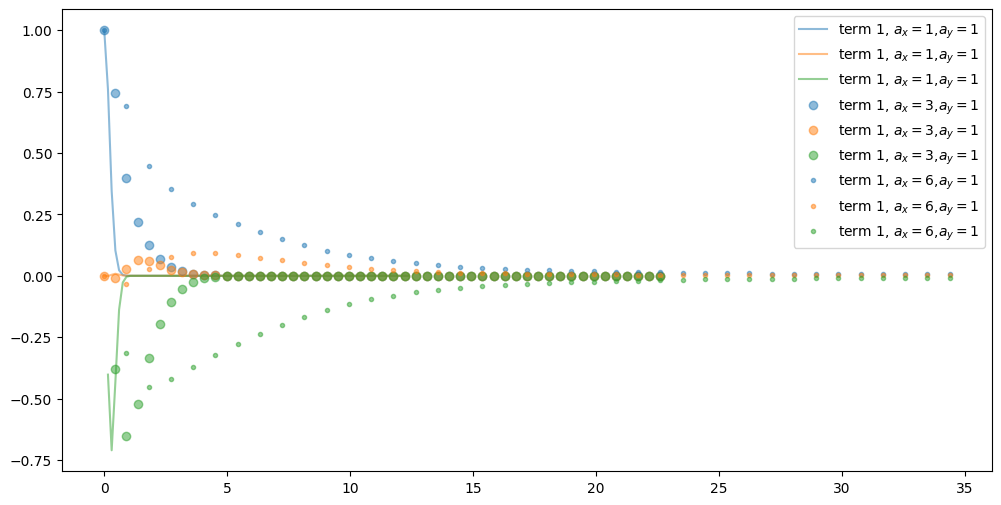

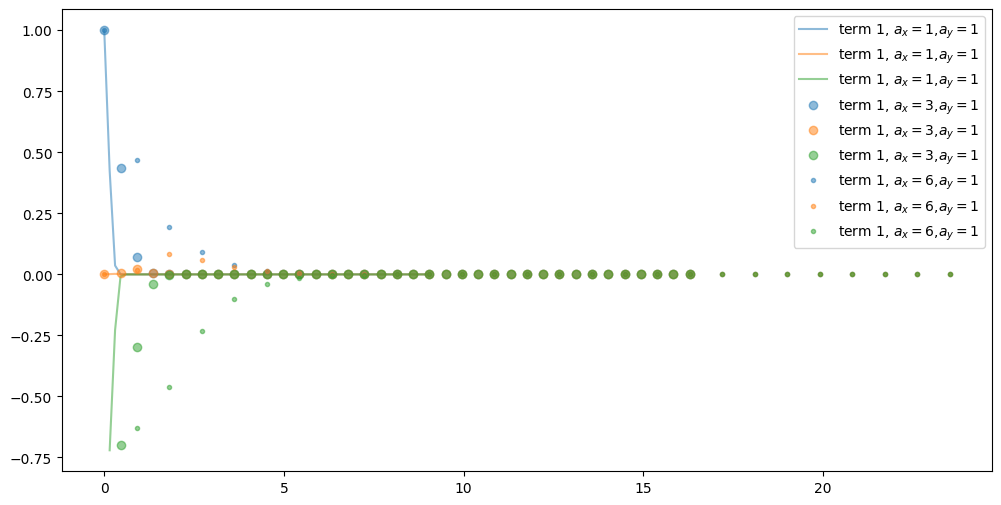

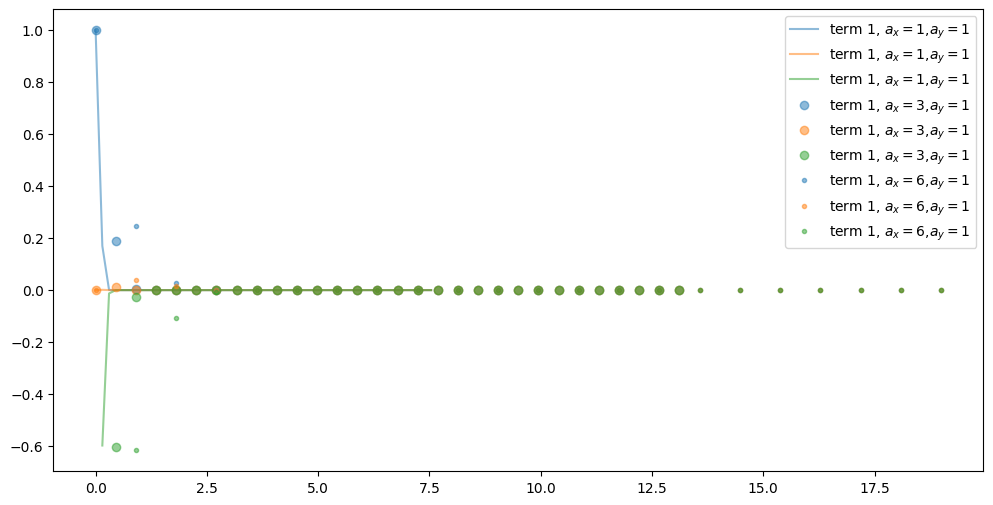

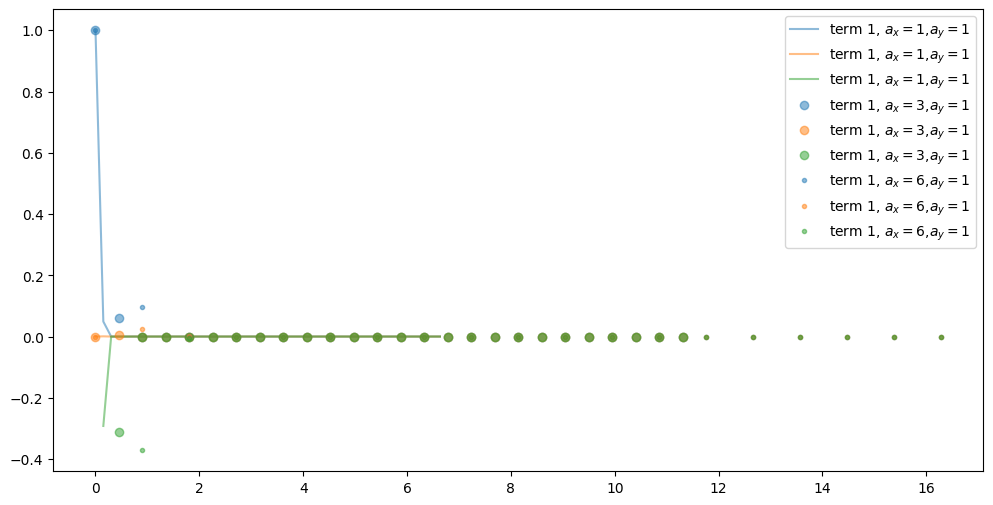

In [38]:



dx_vec = np.linspace(1,20,100)
ax = [1,3,6]
ay = [1,1,1]

_fw = 30
_dy = 0

sig_s_x,sig_s_y = 200e-6 , 200e-6
sig_w_x,sig_w_y = 200e-6 , 200e-6
_r     = sig_s_y/sig_s_x
_A_w_s = sig_w_x/sig_s_y
_B_w_s = sig_w_y/sig_s_x



# FOR LR

for _dx in dx_vec[::20]:

    plt.figure(figsize=(12,6))

    for _ax,_ay,ls in zip(ax,ay,['-','o','.','x','p','s']):

        phi = np.linspace(0,_r*_ax*_fw,200)


        psix = _dx/_ax/_r
        psiy = _ay/_ax/_r
        psiz = _dy/_ax

        axb = phi
        ayb = phi*psiy
        dxb = phi*psix
        dyb = phi*psiz


        # Maybe phi*term?
        term1 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,0) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term2 = np.array([dtune.Qmz(_ayb,_dyb,0)*( dtune.Qmz(_axb,_dxb,2)  ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])
        term3 = np.array([dtune.Qmz(_ayb,_dyb,0)*( - 2*_dxb/_axb* dtune.Qmz(_axb,_dxb,1) ) for _axb,_ayb,_dxb,_dyb in zip(axb,ayb,dxb,dyb)])

        plt.plot(phi,term1,ls,color='C0',alpha=0.5,label=rf'term 1, $a_x = {_ax}$,$a_y = 1$')
        plt.plot(phi,term2,ls,color='C1',alpha=0.5,label=rf'term 2, $a_x = {_ax}$,$a_y = 1$')
        plt.plot(phi,term3,ls,color='C2',alpha=0.5,label=rf'term 3, $a_x = {_ax}$,$a_y = 1$')
    plt.legend()


Output()

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: RuntimeWarning: overflow encountered in 
double_scalars
  return np.exp(-u1-u2)/2/np.pi*integrate.quad(lambda phi:

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:62: RuntimeWarning: invalid value encountered 
in double_scalars
  return np.exp(-t/2*(azb-dzb)**2)*Bess2D(u1,u2,n)

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:92: IntegrationWarning: The occurrence of 
roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return (-2/ax**2)*(fw**2)* integrate.quad(lambda phi:

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:108: IntegrationWarning: The occurrence of 
roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return (-2/ax**2)*(fw**2)* integrate.quad(lambda phi:

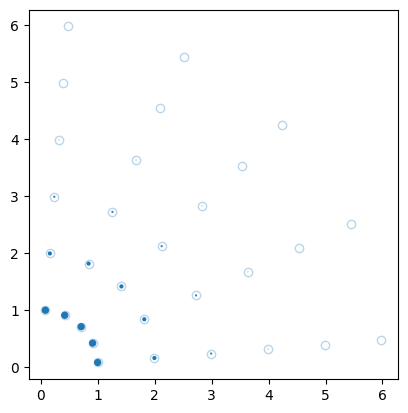

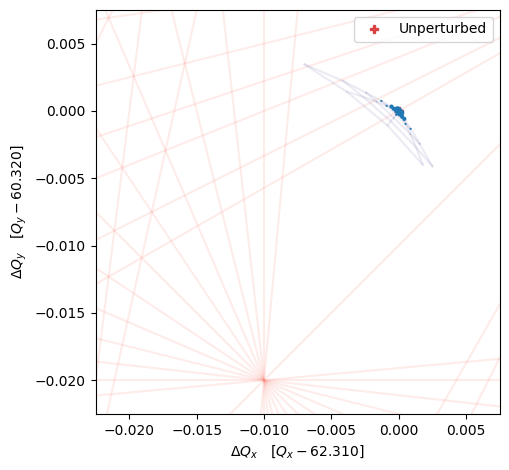

In [17]:
aaa

coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,23),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                emitt     = [B1.emittx,B1.emitty])

coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6,6),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                emitt     = [B1.emittx,B1.emitty])


# Plotting coordinates
#-----------------------
plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o',color='C0',mfc='none',alpha=0.3)
plt.scatter(coordinates['x_sig'],coordinates['y_sig'],s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
#=========================================================


window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]



plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')

# COMPUTE TUNESHIT
#==============================

DQx,DQy= np.zeros(len(coordinates)),np.zeros(len(coordinates))
with rich.progress.Progress() as progress:

    task1 = progress.add_task("[red] IP progress", total=2)
    task2 = progress.add_task("[red] LR progress", total=len(IP1.lr))
    for IP in [IP1,IP5]:
        for index, _bb in IP.lr.iterrows():
            
            _DQx,_DQy = dtune.DQx_DQy(  ax     = coordinates['x_sig'],
                                        ay     = coordinates['y_sig'],
                                        r      = _bb['r'],
                                        dx_sig = _bb['dx_n'],
                                        dy_sig = _bb['dy_n'],
                                        A_w_s  = _bb['A_w_s'],
                                        B_w_s  = _bb['B_w_s'],
                                        xi     = IP.b2.xi)

            DQx    += _DQx
            DQy    += _DQy
            
            progress.update(task2,advance=1,refresh=True)
        progress.reset(task2)
        progress.update(task1,advance=1,refresh=True)
#==============================

bbplt.polarmesh(DQx,DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(DQx,DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_4D.png',format='png',dpi=300)





In [8]:
IP5.lr.loc['bb_lr.r5b1_01']

s              3.740023e+00
r              9.808707e-01
dx            -1.196950e-03
dy             2.251910e-07
dx_n          -9.335025e+00
dy_n           1.790518e-03
A_w_s          1.025422e+00
B_w_s          9.741767e-01
betx           4.822256e+01
bety           4.523729e+01
k1             3.251722e-05
k3             1.361797e+02
(b1, x_lab)    5.984734e-04
(b1, y_lab)   -1.175603e-07
(b2, x_lab)   -5.984767e-04
(b2, y_lab)    1.076307e-07
Name: bb_lr.r5b1_01, dtype: float64

s             -3.740023e+00
r              1.019047e+00
dx             1.218685e-07
dy             1.196942e-03
dx_n           9.659913e-04
dy_n           9.310237e+00
A_w_s          1.016820e+00
B_w_s          1.015339e+00
betx           4.954648e+01
bety           4.757279e+01
k1            -3.251765e-05
k3             1.361834e+02
(b1, x_lab)   -2.112864e-08
(b1, y_lab)   -5.984695e-04
(b2, x_lab)    1.007399e-07
(b2, y_lab)    5.984727e-04
Name: bb_lr.l1b1_01, dtype: float64

In [10]:
#Testing

def DQx_DQy(ax,ay,dx_sig,dy_sig,A_w_s,B_w_s,r,xi,fw=1):
    """
    Notes: 
    The function expects an array for ax,ay, and a single value for the other parameters
    --------
    ax,ay         -> normalized amplitude, ax = x/sigma_weak
    r             -> sigma_y/sigma_x
    dx_sig,dy_sig -> normalized bb separation, dx_sig = dx/sigma_strong
    xi            -> beam-beam parameter
    A_w_s         -> sigma_w_x/sigma_s_y
    B_w_s         -> sigma_w_y/sigma_s_x
    fw            -> reduction factor, sig_x,y -> sig_x,y/fw
    """
    ax = np.array(ax)
    ay = np.array(ay)

    DQx = xi*(A_w_s**2)*np.array([dtune.DQx_norm(_ax*A_w_s*fw,_ay*B_w_s*fw,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    DQy = xi*(B_w_s**2)*np.array([dtune.DQy_norm(_ax*A_w_s*fw,_ay*B_w_s*fw,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    return DQx,DQy


coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6,6),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                emitt     = [B1.emittx,B1.emitty])


IP  = IP1
_bb = IP.lr.loc['bb_lr.l1b1_01']   
DQx,DQy= np.zeros(len(coordinates)),np.zeros(len(coordinates))

# Taking symmetric single LR
_DQx,_DQy = DQx_DQy(ax     = coordinates['x_sig'],
                    ay     = coordinates['y_sig'],
                    r      = _bb['r'],
                    dx_sig = _bb['dx_n'],
                    dy_sig = _bb['dy_n'],
                    A_w_s  = _bb['A_w_s'],
                    B_w_s  = _bb['B_w_s'],
                    xi     = IP.b2.xi)
DQx    += _DQx
DQy    += _DQy

_DQx,_DQy = DQx_DQy(ax     = coordinates['x_sig'],
                    ay     = coordinates['y_sig'],
                    r      = 1/_bb['r'],
                    dx_sig = _bb['dy_n'],
                    dy_sig = _bb['dx_n'],
                    A_w_s  = _bb['B_w_s'],
                    B_w_s  = _bb['A_w_s'],
                    xi     = IP.b2.xi)
DQx    += _DQx
DQy    += _DQy

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(DQx,DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(DQx,DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_4D.png',format='png',dpi=300)

NameError: name 'Qx_lim' is not defined

<Figure size 640x480 with 0 Axes>

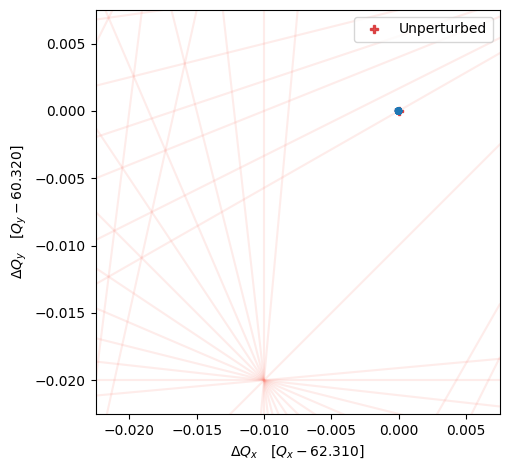

In [11]:
window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(DQx,DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(DQx,DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_4D.png',format='png',dpi=300)

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:46: RuntimeWarning: overflow encountered in exp
  return np.cos(n*phi) * np.exp( u1*np.cos(phi) + u2*np.cos(2*phi))
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return np.exp(-u1-u2)/2/np.pi*integrate.quad(lambda phi:
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  undere

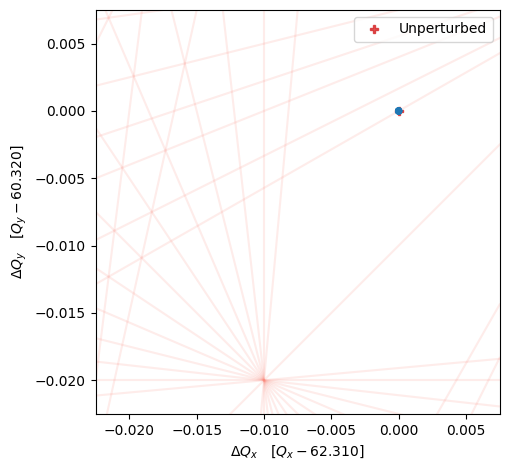

In [25]:
#Testing

def DQx_DQy(ax,ay,dx_sig,dy_sig,A_w_s,B_w_s,r,xi,fw=4):
    """
    Notes: 
    The function expects an array for ax,ay, and a single value for the other parameters
    --------
    ax,ay         -> normalized amplitude, ax = x/sigma_weak
    r             -> sigma_y/sigma_x
    dx_sig,dy_sig -> normalized bb separation, dx_sig = dx/sigma_strong
    xi            -> beam-beam parameter
    A_w_s         -> sigma_w_x/sigma_s_y
    B_w_s         -> sigma_w_y/sigma_s_x
    fw            -> reduction factor, sig_x,y -> sig_x,y/fw
    """
    ax = np.array(ax)
    ay = np.array(ay)

    DQx = xi*(A_w_s**2)*np.array([dtune.DQx_norm(_ax*A_w_s*fw,_ay*B_w_s*fw,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    DQy = xi*(B_w_s**2)*np.array([dtune.DQy_norm(_ax*A_w_s*fw,_ay*B_w_s*fw,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    return DQx,DQy


coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6,6),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                emitt     = [B1.emittx,B1.emitty])


IP  = IP1
_bb = IP.lr.loc['bb_lr.l1b1_01']   
DQx,DQy= np.zeros(len(coordinates)),np.zeros(len(coordinates))

# Taking symmetric single LR
_DQx,_DQy = DQx_DQy(ax     = coordinates['x_sig'],
                    ay     = coordinates['y_sig'],
                    r      = _bb['r'],
                    dx_sig = _bb['dx_n'],
                    dy_sig = _bb['dy_n'],
                    A_w_s  = _bb['A_w_s'],
                    B_w_s  = _bb['B_w_s'],
                    xi     = IP.b2.xi)
DQx    += _DQx
DQy    += _DQy

_DQx,_DQy = DQx_DQy(ax     = coordinates['x_sig'],
                    ay     = coordinates['y_sig'],
                    r      = 1/_bb['r'],
                    dx_sig = _bb['dy_n'],
                    dy_sig = _bb['dx_n'],
                    A_w_s  = _bb['B_w_s'],
                    B_w_s  = _bb['A_w_s'],
                    xi     = IP.b2.xi)
DQx    += _DQx
DQy    += _DQy


window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(DQx,DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(DQx,DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_4D.png',format='png',dpi=300)

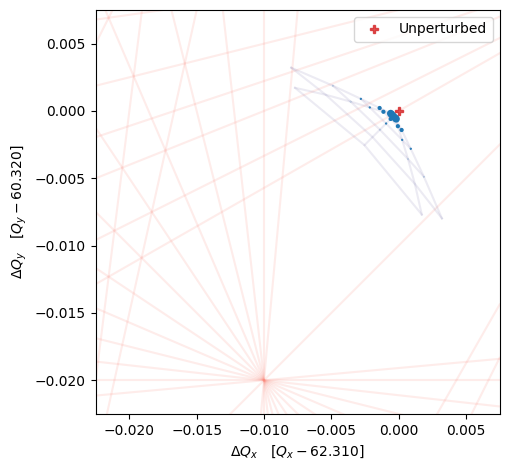

In [30]:
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
bbplt.polarmesh(1000*DQx,1000*DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.scatter(1000*DQx,1000*DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)
plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
plt.tight_layout()
plt.savefig('tuneshift_4D.png',format='png',dpi=300)

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:46: RuntimeWarning: overflow encountered in exp
  return np.cos(n*phi) * np.exp( u1*np.cos(phi) + u2*np.cos(2*phi))
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.exp(-u1-u2)/2/np.pi*integrate.quad(lambda phi:
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should

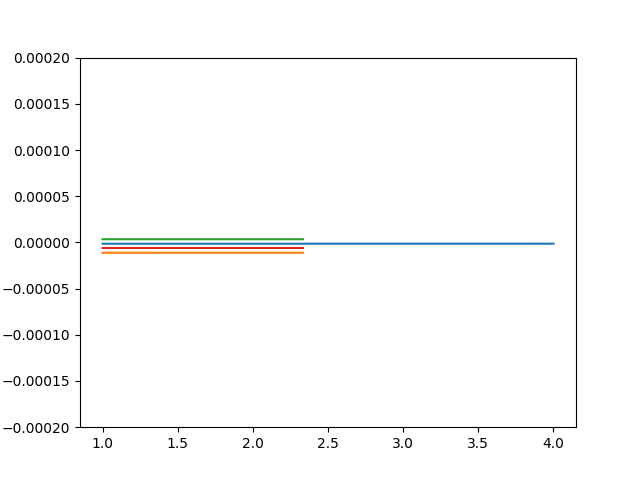

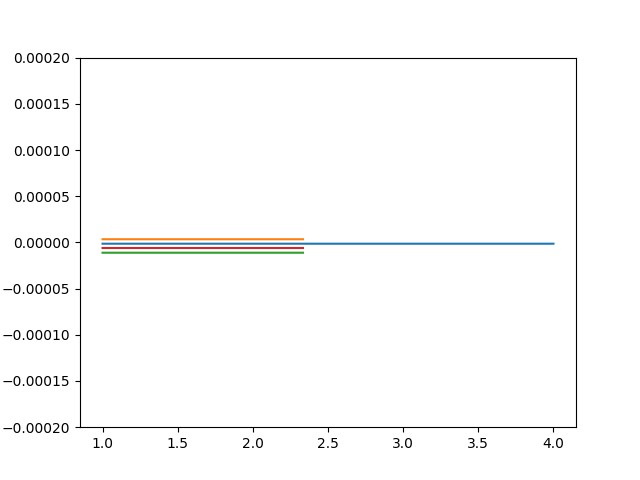

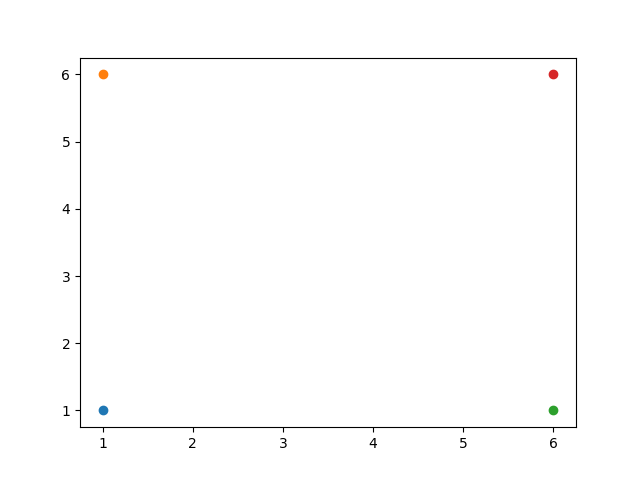

In [50]:
#Testing

def DQx_DQy(ax,ay,dx_sig,dy_sig,A_w_s,B_w_s,r,xi,fw=4):
    """
    Notes: 
    The function expects an array for ax,ay, and a single value for the other parameters
    --------
    ax,ay         -> normalized amplitude, ax = x/sigma_weak
    r             -> sigma_y/sigma_x
    dx_sig,dy_sig -> normalized bb separation, dx_sig = dx/sigma_strong
    xi            -> beam-beam parameter
    A_w_s         -> sigma_w_x/sigma_s_y
    B_w_s         -> sigma_w_y/sigma_s_x
    fw            -> reduction factor, sig_x,y -> sig_x,y/fw
    """
    ax = np.array(ax)
    ay = np.array(ay)

    DQx = xi*(A_w_s**2)*np.array([dtune.DQx_norm(_ax*A_w_s*fw,_ay*B_w_s*fw,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    DQy = xi*(B_w_s**2)*np.array([dtune.DQy_norm(_ax*A_w_s*fw,_ay*B_w_s*fw,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    return DQx,DQy


coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6,6),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                emitt     = [B1.emittx,B1.emitty])


IP  = IP1
_bb = IP.lr.loc['bb_lr.l1b1_01']   

results_x = []
results_y = []
fw_list = np.linspace(1,4,10)
for _fw in fw_list:
    DQx,DQy= np.zeros(4),np.zeros(4)
    # Taking symmetric single LR
    _DQx,_DQy = DQx_DQy(fw = _fw,
                        ax     = [1,1,6,6],
                        ay     = [1,6,1,6],
                        r      = _bb['r'],
                        dx_sig = 2*_bb['dx_n'],
                        dy_sig = 2*_bb['dy_n'],
                        A_w_s  = _bb['A_w_s'],
                        B_w_s  = _bb['B_w_s'],
                        xi     = IP.b2.xi)
    DQx    += _DQx*_fw**2
    DQy    += _DQy*_fw**2

    _DQx,_DQy = DQx_DQy(fw = _fw,
                        ax     = [1,1,6,6],
                        ay     = [1,6,1,6],
                        r      = 1/_bb['r'],
                        dx_sig = 2*_bb['dy_n'],
                        dy_sig = 2*_bb['dx_n'],
                        A_w_s  = _bb['B_w_s'],
                        B_w_s  = _bb['A_w_s'],
                        xi     = IP.b2.xi)
    DQx    += _DQx*_fw**2
    DQy    += _DQy*_fw**2

    results_x.append(DQx)
    results_y.append(DQy)


plt.figure()
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,0])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,1])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,2])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,3])
plt.ylim([-2e-4,2e-4])
plt.figure()
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,0])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,1])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,2])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,3])
plt.ylim([-2e-4,2e-4])
plt.figure()
for _x,_y in zip([1,1,6,6],[1,6,1,6]):
    plt.plot(_x,_y,'o')

# plt.figure()
# bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
# bbplt.polarmesh(DQx,DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
# plt.scatter(DQx,DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
# plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
# plt.legend(loc='upper right')
# plt.axis('square')
# plt.xlim(np.array(Qx_lim)-Qx_0)
# plt.ylim(np.array(Qy_lim)-Qy_0)
# plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
# plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
# plt.tight_layout()
# plt.savefig('tuneshift_4D.png',format='png',dpi=300)

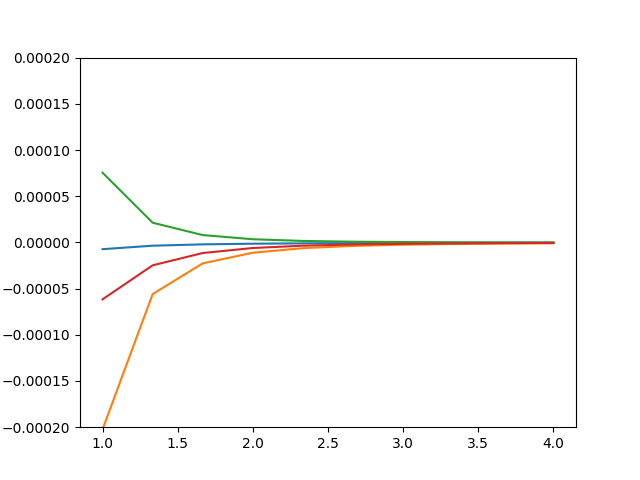

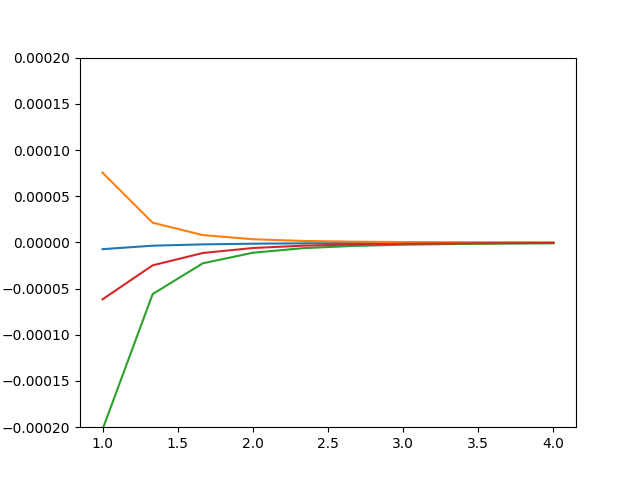

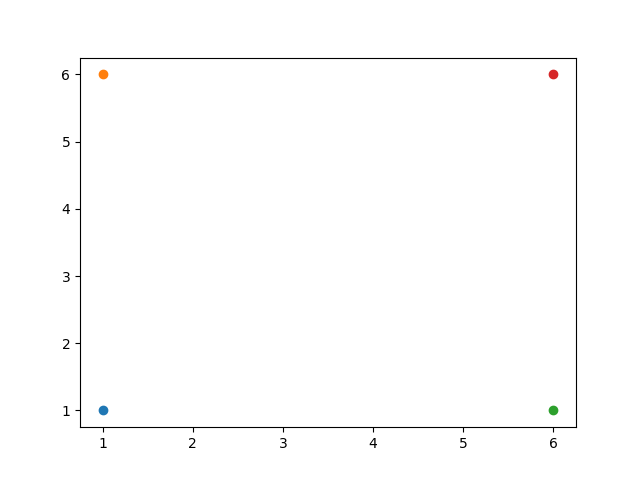

In [47]:
#Testing

def DQx_DQy(ax,ay,dx_sig,dy_sig,A_w_s,B_w_s,r,xi,fw=4):
    """
    Notes: 
    The function expects an array for ax,ay, and a single value for the other parameters
    --------
    ax,ay         -> normalized amplitude, ax = x/sigma_weak
    r             -> sigma_y/sigma_x
    dx_sig,dy_sig -> normalized bb separation, dx_sig = dx/sigma_strong
    xi            -> beam-beam parameter
    A_w_s         -> sigma_w_x/sigma_s_y
    B_w_s         -> sigma_w_y/sigma_s_x
    fw            -> reduction factor, sig_x,y -> sig_x,y/fw
    """
    ax = np.array(ax)
    ay = np.array(ay)

    DQx = xi*(A_w_s**2)*np.array([dtune.DQx_norm(_ax*A_w_s,_ay*B_w_s,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    DQy = xi*(B_w_s**2)*np.array([dtune.DQy_norm(_ax*A_w_s,_ay*B_w_s,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    return DQx,DQy


coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6,6),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                emitt     = [B1.emittx,B1.emitty])


IP  = IP1
_bb = IP.lr.loc['bb_lr.l1b1_01']   

results_x = []
results_y = []
fw_list = np.linspace(1,4,10)
for _fw in fw_list:
    DQx,DQy= np.zeros(4),np.zeros(4)
    # Taking symmetric single LR
    _DQx,_DQy = DQx_DQy(fw = _fw,
                        ax     = [1,1,6,6],
                        ay     = [1,6,1,6],
                        r      = _bb['r'],
                        dx_sig = _bb['dx_n'],
                        dy_sig = _bb['dy_n'],
                        A_w_s  = _bb['A_w_s'],
                        B_w_s  = _bb['B_w_s'],
                        xi     = IP.b2.xi)
    DQx    += _DQx
    DQy    += _DQy

    _DQx,_DQy = DQx_DQy(fw = _fw,
                        ax     = [1,1,6,6],
                        ay     = [1,6,1,6],
                        r      = 1/_bb['r'],
                        dx_sig = _bb['dy_n'],
                        dy_sig = _bb['dx_n'],
                        A_w_s  = _bb['B_w_s'],
                        B_w_s  = _bb['A_w_s'],
                        xi     = IP.b2.xi)
    DQx    += _DQx
    DQy    += _DQy

    results_x.append(DQx)
    results_y.append(DQy)


plt.figure()
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,0])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,1])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,2])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,3])
plt.ylim([-2e-4,2e-4])
plt.figure()
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,0])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,1])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,2])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,3])
plt.ylim([-2e-4,2e-4])
plt.figure()
for _x,_y in zip([1,1,6,6],[1,6,1,6]):
    plt.plot(_x,_y,'o')

# plt.figure()
# bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
# bbplt.polarmesh(DQx,DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
# plt.scatter(DQx,DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
# plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
# plt.legend(loc='upper right')
# plt.axis('square')
# plt.xlim(np.array(Qx_lim)-Qx_0)
# plt.ylim(np.array(Qy_lim)-Qy_0)
# plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
# plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
# plt.tight_layout()
# plt.savefig('tuneshift_4D.png',format='png',dpi=300)

-3.2517654301063464e-05

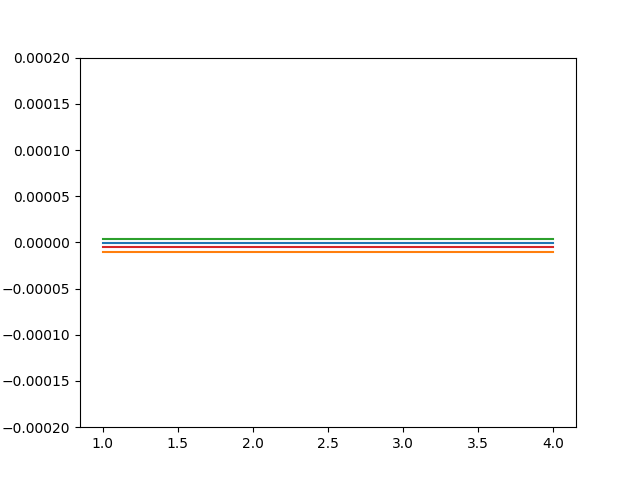

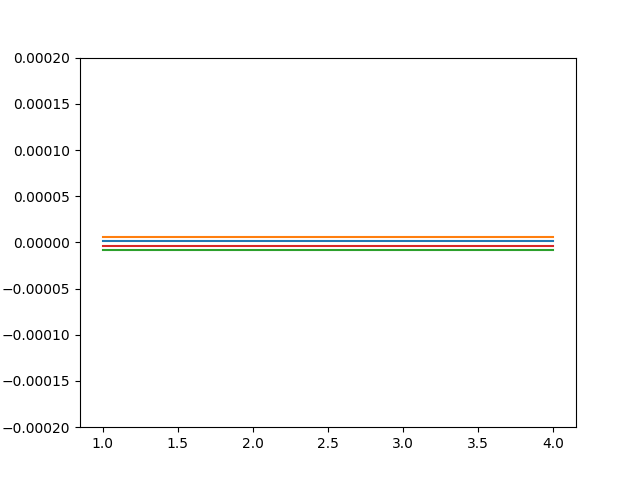

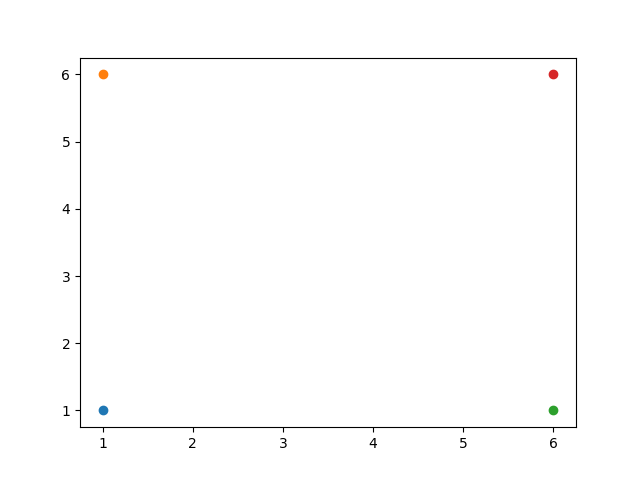

In [55]:
#Testing

def DQx_DQy(ax,ay,dx_sig,dy_sig,A_w_s,B_w_s,r,xi,fw=4):
    """
    Notes: 
    The function expects an array for ax,ay, and a single value for the other parameters
    --------
    ax,ay         -> normalized amplitude, ax = x/sigma_weak
    r             -> sigma_y/sigma_x
    dx_sig,dy_sig -> normalized bb separation, dx_sig = dx/sigma_strong
    xi            -> beam-beam parameter
    A_w_s         -> sigma_w_x/sigma_s_y
    B_w_s         -> sigma_w_y/sigma_s_x
    fw            -> reduction factor, sig_x,y -> sig_x,y/fw
    """
    ax = np.array(ax)
    ay = np.array(ay)

    DQx = xi*(A_w_s**2)*np.array([dtune.DQx_norm(_ax*A_w_s,_ay*B_w_s,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    DQy = xi*(B_w_s**2)*np.array([dtune.DQy_norm(_ax*A_w_s,_ay*B_w_s,dx_sig*fw,dy_sig*fw,r) for _ax,_ay in zip(ax,ay)])
    return DQx,DQy


coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6,6),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,5),
                                emitt     = [B1.emittx,B1.emitty])


IP  = IP1
_bb = IP.lr.loc['bb_lr.l1b1_01']   

results_x = []
results_y = []
fw_list = np.linspace(1,4,10)
for _fw in fw_list:
    DQx,DQy= np.zeros(4),np.zeros(4)
    # Taking symmetric single LR

    IP  = IP1
    _bb = IP.lr.loc['bb_lr.l1b1_01'] 
    _DQx,_DQy = dtune.BBLR_octupole(    np.array([1,1,6,6])**2*B1.emittx/2,
                                        np.array([1,6,1,6])**2*B1.emittx/2,
                                        betx = _bb['betx'],
                                        bety = _bb['bety'],
                                        k1   = IP.b2.strong_knl(2*_bb['dx'],2*_bb['dy'])[0][1],
                                        k3   = IP.b2.strong_knl(2*_bb['dx'],2*_bb['dy'])[0][3])
    DQx    += _DQx
    DQy    += _DQy

    IP  = IP5
    _bb = IP.lr.loc['bb_lr.r5b1_01'] 
    _DQx,_DQy = dtune.BBLR_octupole(    np.array([1,1,6,6])**2*B1.emittx/2,
                                        np.array([1,6,1,6])**2*B1.emittx/2,
                                        betx = _bb['betx'],
                                        bety = _bb['bety'],
                                        k1   = IP.b2.strong_knl(2*_bb['dx'],2*_bb['dy'])[0][1],
                                        k3   = IP.b2.strong_knl(2*_bb['dx'],2*_bb['dy'])[0][3])
    DQx    += _DQx
    DQy    += _DQy

    results_x.append(DQx)
    results_y.append(DQy)

    



plt.figure()
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,0])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,1])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,2])
plt.plot(np.linspace(1,4,10),np.array(results_x)[:,3])

plt.ylim([-2e-4,2e-4])

plt.figure()
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,0])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,1])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,2])
plt.plot(np.linspace(1,4,10),np.array(results_y)[:,3])


plt.ylim([-2e-4,2e-4])

plt.figure()
for _x,_y in zip([1,1,6,6],[1,6,1,6]):
    plt.plot(_x,_y,'o')

# plt.figure()
# bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
# bbplt.polarmesh(DQx,DQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
# plt.scatter(DQx,DQy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
# plt.plot([0],[0],'P',color='C3',alpha=0.8,label='Unperturbed')
# plt.legend(loc='upper right')
# plt.axis('square')
# plt.xlim(np.array(Qx_lim)-Qx_0)
# plt.ylim(np.array(Qy_lim)-Qy_0)
# plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$')
# plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$')
# plt.tight_layout()
# plt.savefig('tuneshift_4D.png',format='png',dpi=300)


/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:46: RuntimeWarning: overflow encountered in exp
  return np.cos(n*phi) * np.exp( u1*np.cos(phi) + u2*np.cos(2*phi))
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return np.exp(-u1-u2)/2/np.pi*integrate.quad(lambda phi:
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  undere

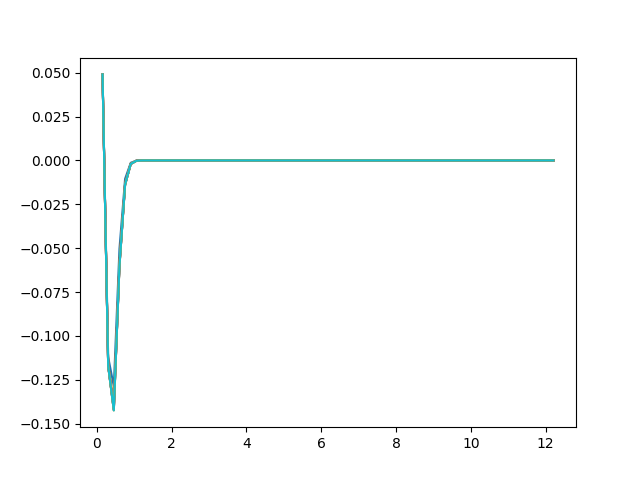

In [68]:
phi = np.linspace(0,30,200)


plt.figure()
for ax in [1,2,3,4,5,6,7,8,9,10]:
#ax = 6
    ay = 0
    dx = 10
    dy = 1
    r  = 1

    psix = 5#dx/ax/r
    psiy = ay/ax/r
    psiz = dy/ax
    kernel = np.array([_phi*dtune.TSX_kern( axb = _phi,
                                            ayb = _phi*psiy,
                                            dxb = _phi*psix,
                                            dyb = _phi*psiz) for _phi in phi])


    plt.plot(phi,kernel)